In [79]:
from sklearn.datasets import load_files
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.decomposition import LatentDirichletAllocation
import nltk
from nltk.cluster import KMeansClusterer
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import string
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import json
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import pyLDAvis
import pyLDAvis.sklearn
import math
import copy
from wordcloud import WordCloud
%matplotlib inline

# 1. Read articles from text file

In [80]:
articles = None
filename = '52_articles(working).txt'
folder_name = 'Local_dataset'
with open(folder_name + '/' + filename) as json_file:  
    articles = json.load(json_file)
df = pd.DataFrame(articles)
df

,authors,body,dataType,date,dateTime,eventUri,image,isDuplicate,lang,sentiment,sim,source,time,title,uri,url,wgt
0,"[{'uri': 'ana_swanson@nytimes.com', 'name': 'A...",WASHINGTON -- The United States and China are ...,news,2019-05-23,2019-05-23T17:39:00Z,eng-4800969,https://static01.nyt.com/images/2019/05/23/bus...,False,eng,-0.200000,0.560784,"{'uri': 'nytimes.com', 'dataType': 'news', 'ti...",17:39:00,Trump Gives Farmers $16 Billion in Aid Amid Pr...,1143836481,https://www.nytimes.com/2019/05/23/us/politics...,296329140
1,"[{'uri': 'ana_swanson@nytimes.com', 'name': 'A...",WASHINGTON -- The Trump administration is prep...,news,2019-05-23,2019-05-23T12:19:00Z,eng-4800969,https://static01.nyt.com/images/2019/05/23/bus...,False,eng,-0.349020,0.533333,"{'uri': 'nytimes.com', 'dataType': 'news', 'ti...",12:19:00,Trump Administration to Announce Farm Aid to E...,1143567051,https://www.nytimes.com/2019/05/23/us/politics...,296309940
2,"[{'uri': 'ana_swanson@nytimes.com', 'name': 'A...",WASHINGTON -- President Trump agreed on Friday...,news,2019-05-22,2019-05-22T15:42:00Z,None,https://static01.nyt.com/images/2019/05/17/us/...,False,eng,0.074510,0.000000,"{'uri': 'nytimes.com', 'dataType': 'news', 'ti...",15:42:00,Trump Lifts Metal Tariffs and Delays Auto Levi...,1142795786,https://www.nytimes.com/2019/05/17/us/politics...,296235720
3,"[{'uri': 'alexandra_stevenson@nytimes.com', 'n...",BEIJING -- President Xi Jinping of China has c...,news,2019-05-22,2019-05-22T03:15:00Z,eng-4801161,https://static01.nyt.com/images/2019/05/22/wor...,False,eng,-0.105882,0.498039,"{'uri': 'nytimes.com', 'dataType': 'news', 'ti...",03:15:00,China Faces New 'Long March' as Trade War Inte...,1141957321,https://www.nytimes.com/2019/05/21/world/asia/...,296190900
4,"[{'uri': 'raymond_zhong@nytimes.com', 'name': ...",BEIJING -- When the United States ratcheted up...,news,2019-05-21,2019-05-21T21:20:00Z,eng-4800969,https://static01.nyt.com/images/2019/05/10/wor...,False,eng,-0.082353,0.552941,"{'uri': 'nytimes.com', 'dataType': 'news', 'ti...",21:20:00,"China, Defiant but Careful, Promises Aggressiv...",1141791849,https://www.nytimes.com/2019/05/10/business/ch...,296169600
5,"[{'uri': 'ana_swanson@nytimes.com', 'name': 'A...",WASHINGTON -- President Trump escalated his tr...,news,2019-05-21,2019-05-21T21:20:00Z,eng-4800969,https://static01.nyt.com/images/2019/05/09/bus...,False,eng,-0.090196,0.635294,"{'uri': 'nytimes.com', 'dataType': 'news', 'ti...",21:20:00,Trump Increases China Tariffs as Trade Deal Ha...,1141791852,https://www.nytimes.com/2019/05/09/us/politics...,296169600
6,"[{'uri': 'ana_swanson@nytimes.com', 'name': 'A...",WASHINGTON -- A yearlong trade war between the...,news,2019-05-21,2019-05-21T21:20:00Z,eng-4800969,https://static01.nyt.com/images/2019/05/12/us/...,False,eng,0.176471,0.470588,"{'uri': 'nytimes.com', 'dataType': 'news', 'ti...",21:20:00,U.S.-China Trade Standoff May Be Initial Skirm...,1141791846,https://www.nytimes.com/2019/05/11/world/asia/...,296169600
7,"[{'uri': 'keith_bradsher@nytimes.com', 'name':...","A week ago, the United States and China looked...",news,2019-05-21,2019-05-21T21:20:00Z,eng-4800969,https://static01.nyt.com/images/2019/05/09/wor...,False,eng,-0.129412,0.780392,"{'uri': 'nytimes.com', 'dataType': 'news', 'ti...",21:20:00,Trump Could Raise Tariffs on China. Here's How...,1141791853,https://www.nytimes.com/2019/05/09/business/tr...,296169600
8,"[{'uri': 'li_yuan@nytimes.com', 'name': 'Li Yu...",Wu Shichun is one of countless Chinese entrepr...,news,2019-05-21,2019-05-21T21:20:00Z,None,https://static01.nyt.com/images/2019/05/14/bus...,False,eng,0.003922,0.000000,"{'uri': 'nytimes.com', 'dataType': 'news', 'ti...",21:20:00,"In China, Some Fear the End of 'Chimerica'",1141791843,https://www.nytimes.com/2019/05/14/business/us...,296169600
9,"[{'uri': 'ana_swanson@nytimes.com', 'name': 'A...",WASHINGTON -- The White House has decided to d...,news,2019-05-21,2019-05-21T21:20:00Z,None,https://static01.nyt.com/images/2

# 2. Text processing

In [81]:
lemmatizer = WordNetLemmatizer()
pattern = re.compile('^[$€]?[0-9]+(,[0-9]+)*.?[0-9]*[,.]?$')

def matchesNum(term):
    if re.match(pattern, term):
        return(True)
    else:
        return(False)

def removePunctuation(term):
    return term.translate(str.maketrans('', '', string.punctuation))

def updateNumbers(text):
    split_text = text.split(' ')
    updated_split_text=[]
    term_num=len(split_text)
    i = 0
    while i < term_num:
        if matchesNum(split_text[i]):
        
            if (i+1 < term_num) and (removePunctuation(split_text[i+1])=='million' or removePunctuation(split_text[i+1])=='billion'):
                new_word = split_text[i].translate(str.maketrans('', '', ','))+removePunctuation(split_text[i+1])
                i+=1
            else:
                new_word = split_text[i].translate(str.maketrans('', '', ','))
            new_word = new_word.rstrip('.')
            new_word = new_word.replace('.','dot')
            new_word = new_word.replace('$','dol')
            new_word = new_word.replace('€','eur')
            updated_split_text.append(new_word)
        else:
            updated_split_text.append(split_text[i])
        i+=1
    return ' '.join(updated_split_text)

def process_text(text):
    updated_text = updateNumbers(text)
    words = nltk.word_tokenize(updated_text)
    words = [w.lower() for w in words]
    words = [w.translate(str.maketrans('', '', string.punctuation)) for w in words]
    words = [w for w in words if w not in nltk.corpus.stopwords.words('english')]
    words = [lemmatizer.lemmatize(w) for w in words]
    words = [w for w in words if w.isalnum()]
    new_text = " ".join(words)
    return new_text

# 2.a Process "body" of the article

In [82]:
df['body_processed'] = [process_text(b) for b in df['body']]
df

,authors,body,dataType,date,dateTime,eventUri,image,isDuplicate,lang,sentiment,sim,source,time,title,uri,url,wgt,body_processed
0,"[{'uri': 'ana_swanson@nytimes.com', 'name': 'A...",WASHINGTON -- The United States and China are ...,news,2019-05-23,2019-05-23T17:39:00Z,eng-4800969,https://static01.nyt.com/images/2019/05/23/bus...,False,eng,-0.200000,0.560784,"{'uri': 'nytimes.com', 'dataType': 'news', 'ti...",17:39:00,Trump Gives Farmers $16 Billion in Aid Amid Pr...,1143836481,https://www.nytimes.com/2019/05/23/us/politics...,296329140,washington united state china digging prolonge...
1,"[{'uri': 'ana_swanson@nytimes.com', 'name': 'A...",WASHINGTON -- The Trump administration is prep...,news,2019-05-23,2019-05-23T12:19:00Z,eng-4800969,https://static01.nyt.com/images/2019/05/23/bus...,False,eng,-0.349020,0.533333,"{'uri': 'nytimes.com', 'dataType': 'news', 'ti...",12:19:00,Trump Administration to Announce Farm Aid to E...,1143567051,https://www.nytimes.com/2019/05/23/us/politics...,296309940,washington trump administration preparing anno...
2,"[{'uri': 'ana_swanson@nytimes.com', 'name': 'A...",WASHINGTON -- President Trump agreed on Friday...,news,2019-05-22,2019-05-22T15:42:00Z,None,https://static01.nyt.com/images/2019/05/17/us/...,False,eng,0.074510,0.000000,"{'uri': 'nytimes.com', 'dataType': 'news', 'ti...",15:42:00,Trump Lifts Metal Tariffs and Delays Auto Levi...,1142795786,https://www.nytimes.com/2019/05/17/us/politics...,296235720,washington president trump agreed friday lift ...
3,"[{'uri': 'alexandra_stevenson@nytimes.com', 'n...",BEIJING -- President Xi Jinping of China has c...,news,2019-05-22,2019-05-22T03:15:00Z,eng-4801161,https://static01.nyt.com/images/2019/05/22/wor...,False,eng,-0.105882,0.498039,"{'uri': 'nytimes.com', 'dataType': 'news', 'ti...",03:15:00,China Faces New 'Long March' as Trade War Inte...,1141957321,https://www.nytimes.com/2019/05/21/world/asia/...,296190900,beijing president xi jinping china called chin...
4,"[{'uri': 'raymond_zhong@nytimes.com', 'name': ...",BEIJING -- When the United States ratcheted up...,news,2019-05-21,2019-05-21T21:20:00Z,eng-4800969,https://static01.nyt.com/images/2019/05/10/wor...,False,eng,-0.082353,0.552941,"{'uri': 'nytimes.com', 'dataType': 'news', 'ti...",21:20:00,"China, Defiant but Careful, Promises Aggressiv...",1141791849,https://www.nytimes.com/2019/05/10/business/ch...,296169600,beijing united state ratcheted trade tension b...
5,"[{'uri': 'ana_swanson@nytimes.com', 'name': 'A...",WASHINGTON -- President Trump escalated his tr...,news,2019-05-21,2019-05-21T21:20:00Z,eng-4800969,https://static01.nyt.com/images/2019/05/09/bus...,False,eng,-0.090196,0.635294,"{'uri': 'nytimes.com', 'dataType': 'news', 'ti...",21:20:00,Trump Increases China Tariffs as Trade Deal Ha...,1141791852,https://www.nytimes.com/2019/05/09/us/politics...,296169600,washington president trump escalated trade war...
6,"[{'uri': 'ana_swanson@nytimes.com', 'name': 'A...",WASHINGTON -- A yearlong trade war between the...,news,2019-05-21,2019-05-21T21:20:00Z,eng-4800969,https://static01.nyt.com/images/2019/05/12/us/...,False,eng,0.176471,0.470588,"{'uri': 'nytimes.com', 'dataType': 'news', 'ti...",21:20:00,U.S.-China Trade Standoff May Be Initial Skirm...,1141791846,https://www.nytimes.com/2019/05/11/world/asia/...,296169600,washington yearlong trade war united state chi...
7,"[{'uri': 'keith_bradsher@nytimes.com', 'name':...","A week ago, the United States and China looked...",news,2019-05-21,2019-05-21T21:20:00Z,eng-4800969,https://static01.nyt.com/images/2019/05/09/wor...,False,eng,-0.129412,0.780392,"{'uri': 'nytimes.com', 'dataType': 'news', 'ti...",21:20:00,Trump Could Raise Tariffs on China. Here's How...,1141791853,https://www.nytimes.com/2019/05/09/business/tr...,296169600,week ago united state china looked going reach...
8,"[{'uri': 'li_yuan@nytimes.com', 'name': 'Li Yu...",Wu Shichun is one of countless Chinese entrepr...,news,2019-05-21,2019-05-21T21:20:00Z,None,https://static01.ny

# (Optional) Split articles (i.e. old articles vs new article)

In [83]:
# df_new =df.iloc[:1,:]
# df_old = df.iloc[1:,:]

# LDA

In [84]:
df['date'] =pd.to_datetime(df['date'])
df.index = df['date']
df = df.sort_index(ascending=True)
df

,authors,body,dataType,date,dateTime,eventUri,image,isDuplicate,lang,sentiment,sim,source,time,title,uri,url,wgt,body_processed
date,,,,,,,,,,,,,,,,,,
2019-04-26,"[{'uri': 'alan_rappeport@nytimes.com', 'name':...","KENDALL, Wis. -- For decades, Denise and Tom M...",news,2019-04-26,2019-04-26T21:02:00Z,eng-4748614,https://static01.nyt.com/images/2019/04/25/bus...,False,eng,-0.129412,0.541176,"{'uri': 'nytimes.com', 'dataType': 'news', 'ti...",21:02:00,"Stung by Trump's Trade Wars, Wisconsin's Milk ...",1122317868,https://www.nytimes.com/2019/04/26/us/politics...,294008520,kendall wi decade denise tom murray rose 5 shu...
2019-04-28,"[{'uri': 'katie_rogers@nytimes.com', 'name': '...","GREEN BAY, Wis. -- The White House Corresponde...",news,2019-04-28,2019-04-28T03:22:00Z,eng-4754306,https://static01.nyt.com/images/2019/04/27/mul...,False,eng,0.270588,0.521569,"{'uri': 'nytimes.com', 'dataType': 'news', 'ti...",03:22:00,"Even Away From Correspondents' Dinner, Trump M...",1123052938,https://www.nytimes.com/2019/04/27/us/politics...,294117720,green bay wi white house correspondent dinner ...
2019-04-29,"[{'uri': 'alan_rappeport@nytimes.com', 'name':...",LOS ANGELES -- Treasury Secretary Steven Mnuch...,news,2019-04-29,2019-04-29T02:42:00Z,eng-4756436,https://static01.nyt.com/images/2019/04/28/us/...,False,eng,0.247059,0.733333,"{'uri': 'nytimes.com', 'dataType': 'news', 'ti...",02:42:00,Mnuchin Says Trade Negotiations With China Are...,1123637797,https://www.nytimes.com/2019/04/28/us/politics...,294201720,los angeles treasury secretary steven mnuchin ...
2019-04-30,"[{'uri': 'reuters@nytimes.com', 'name': 'Reute...",BEIJING -- U.S. Treasury Secretary Steven Mnuc...,news,2019-04-30,2019-04-30T22:09:00Z,eng-4756436,https://static01.nyt.com/newsgraphics/images/i...,False,eng,0.231373,0.737255,"{'uri': 'nytimes.com', 'dataType': 'news', 'ti...",22:09:00,U.S. Treasury Chief Hopes for 'Substantial Pro...,1125197006,https://www.nytimes.com/reuters/2019/04/30/bus...,294358140,beijing u treasury secretary steven mnuchin sa...
2019-05-03,"[{'uri': 'neil_irwin@nytimes.com', 'name': 'Ne...",Maybe using data from a few decades in the mid...,news,2019-05-03,2019-05-03T14:16:00Z,None,https://static01.nyt.com/images/2019/05/02/ups...,False,eng,-0.090196,0.000000,"{'uri': 'nytimes.com', 'dataType': 'news', 'ti...",14:16:00,The Economy That Wasn't Supposed to Happen: Bo...,1127368365,https://www.nytimes.com/2019/05/03/upshot/unem...,294588960,maybe using data decade middle 20th century se...
2019-05-03,"[{'uri': 'nelson_d_schwartz@nytimes.com', 'nam...",Analysts expect the figures to show strong hir...,news,2019-05-03,2019-05-03T09:08:00Z,None,https://static01.nyt.com/images/2019/05/03/bus...,False,eng,0.215686,0.000000,"{'uri': 'nytimes.com', 'dataType': 'news', 'ti...",09:08:00,April Jobs Report: Here's What to Watch For,1127146143,https://www.nytimes.com/2019/05/03/business/ec...,294570480,analyst expect figure show strong hiring fear ...
2019-05-06,"[{'uri': 'keith_bradsher@nytimes.com', 'name':...",The prospect of a wider trade war between the ...,news,2019-05-06,2019-05-06T09:25:00Z,eng-4766536,https://static01.nyt.com/newsgraphics/images/i...,False,eng,-0.050980,0.596078,"{'uri': 'nytimes.com', 'dataType': 'news', 'ti...",09:25:00,Trump's Trade War Threat Poses Problems for Ch...,1129125411,https://www.nytimes.com/2019/05/06/business/ch...,294830700,prospect wider trade war united state china se...
2019-05-06,"[{'uri': 'ana_swanson@nytimes.com', 'name': 'A...",WASHINGTON -- President Trump's threat to impo...,news,2019-05-06,2019-05-06T19:39:00Z,eng-4766536,https://static01.nyt.com/images/2019/05/06/bus...,False,eng,0.137255,0.686275,"{'uri': 'nytimes.com', 'dataType': 'news', 'ti...",19:39:00,Trump's Tariff Threat Stemmed From Concerns U....,1129553437,https://www.nytimes.com/2019/05/06/us/politics...,294867540,washington president trump threat impose tarif...
2019-05-07,"[{'uri': 'yi_zheng_lian@nytimes.com', 'name': ...",Mr. Lian is a forme

In [85]:
class NCA:
    
    def __init__(self,depth=1,init_topics=-1):
        self.depth = depth
        self.init_topics = init_topics
        self.models = []
        
    def fit(self,df):
        current_topics = self.init_topics
        if current_topics == -1:
            current_topics = min(20,min(math.ceil(df.shape[0]/3) + 1, df.shape[0]))
            
        for i in range(self.depth):
            
            #perfom fitting and transforming
            vect = TfidfVectorizer(sublinear_tf=True,ngram_range=(1,3),max_df=0.7).fit(df['body_processed'])
            X_train = vect.transform(df['body_processed'])
            lda = LatentDirichletAllocation(n_components=current_topics,random_state=0,max_iter=400,learning_method='batch')
            lda.fit(X_train)
            transformed = lda.transform(X_train)
            
            #save model
            model = {}
            model['lda'] = lda
            model['transformed'] = transformed
            model['topics'] = current_topics
            model['vect'] = vect
            model['X_train'] = X_train
            model['df'] = df
            self.models.append(model)
            
            topic_result = {}
            if i != self.depth-1:
                for i in range(len(transformed)):
                    max_num = -99
                    max_index = -99
                    for j in range(len(transformed[i])):
                        if transformed[i][j] >= max_num:
                            max_num = transformed[i][j]
                            max_index = j
                    if max_index not in topic_result:
                        topic_result[max_index] = []
                    topic_result[max_index].append(i)
                
                index = df.shape[0]-1
                subtopic = None
                for t in topic_result:
                    for a in topic_result[t]:
                        if a == index:
                            subtopic=t
                            break

                df = df.iloc[topic_result[subtopic]]
                current_topics = min(20,min(math.ceil(df.shape[0]/3) + 1, df.shape[0]))
            
    def stacked_barplot(self,depth=-1):
        
        if depth == -1:
            depth = self.depth
        
        for i in range(depth):
            current_model = self.models[i]
            transformed = current_model['transformed']
            transformed_copy = copy.deepcopy(transformed)
            topics = current_model['topics']
            
            plt.figure()
            x=range(0, topics)
            prev = None
            first = True
            width = 0.5
            bars = []
            for i in range(len(transformed_copy)): 
                p = plt.bar(x, transformed_copy[i], width, bottom=prev)
                if first:
                    prev = transformed_copy[i]
                    first = False
                else:
                    prev += transformed_copy[i]
                bars.append(p)
            if len(transformed_copy) <= 15:
                articles_num = range(1,len(transformed_copy)+1)
                plt.legend([p[0] for p in bars],[a for a in articles_num])
                
    def pyldavis(self,depth=-1):
        
        if depth == -1:
            depth = self.depth
            
        pyLDAvis.enable_notebook()
        for i in range(depth):
            current_model = self.models[i]
            panel = pyLDAvis.sklearn.prepare(current_model['lda'], current_model['X_train'], current_model['vect'], mds='tsne')
            display(panel)
            
    def topic_distribution(self,depth=-1):
        if depth == -1:
            depth = self.depth
        print("************************************************************")
        for z in range(depth):
            current_model = self.models[z]
            transformed = current_model['transformed']            
            for i in range(len(transformed)):
                max_num = -99
                max_index = -99
                for j in range(len(transformed[i])):
                    if transformed[i][j] >= max_num:
                        max_num = transformed[i][j]
                        max_index = j
                print('max topic of doc ' + str(i) + ' is: ' + str(max_index))
                
            print("*********************************************************")
            
    def print_LDA_results(self,lda_model, feature_names, n_top_words=50):
        for topic_idx, topic in enumerate(lda_model.components_):
            message = "Topic %d: " % topic_idx
            message += " ".join([("*" + feature_names[i] + "*")
                                 for i in topic.argsort()[:-n_top_words - 1:-1]])
            print(message)
            print()
            
    def print_topics(self,depth=-1):
        if depth == -1:
            depth = self.depth
        print("************************************************************")
        for i in range(depth):
            current_model = self.models[i]
            lda = current_model['lda']
            vect = current_model['vect']
            self.print_LDA_results(lda,vect.get_feature_names())
            print("************************************************************")
            
    def word_cloud(self,depth=-1):
        if depth == -1:
            depth = self.depth
        
        for i in range(depth):
            current_model = self.models[i]
            df = current_model['df']
            
            df_old = df.iloc[:df.shape[0]-1]
            words = ""
            for text in df_old['body_processed']:
                words+= " " + text
            wordcloud = WordCloud().generate(words)
            plt.imshow(wordcloud, interpolation='bilinear')
            plt.axis("off")
            plt.show()
            plt.figure()
            
            words = df.iloc[df.shape[0]-1]['body_processed']
            wordcloud = WordCloud().generate(words)
            plt.imshow(wordcloud, interpolation='bilinear')
            plt.axis("off")
            plt.show()
            plt.figure() 
            print("************************************************************")


        

In [86]:
nca = NCA(depth=2)
nca.fit(df)

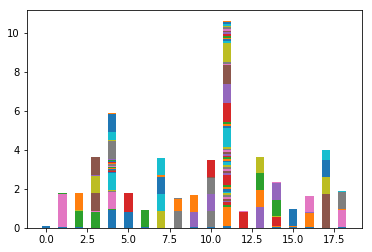

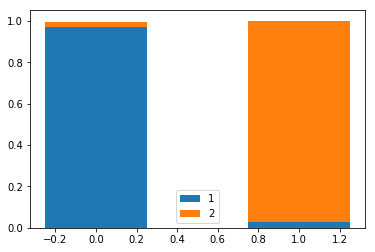

In [87]:
nca.stacked_barplot()

In [88]:
nca.topic_distribution()

************************************************************
max topic of doc 0 is: 4
max topic of doc 1 is: 11
max topic of doc 2 is: 3
max topic of doc 3 is: 12
max topic of doc 4 is: 13
max topic of doc 5 is: 17
max topic of doc 6 is: 4
max topic of doc 7 is: 8
max topic of doc 8 is: 7
max topic of doc 9 is: 4
max topic of doc 10 is: 5
max topic of doc 11 is: 16
max topic of doc 12 is: 2
max topic of doc 13 is: 11
max topic of doc 14 is: 9
max topic of doc 15 is: 17
max topic of doc 16 is: 18
max topic of doc 17 is: 10
max topic of doc 18 is: 17
max topic of doc 19 is: 7
max topic of doc 20 is: 7
max topic of doc 21 is: 8
max topic of doc 22 is: 6
max topic of doc 23 is: 5
max topic of doc 24 is: 10
max topic of doc 25 is: 3
max topic of doc 26 is: 1
max topic of doc 27 is: 10
max topic of doc 28 is: 3
max topic of doc 29 is: 11
max topic of doc 30 is: 15
max topic of doc 31 is: 9
max topic of doc 32 is: 14
max topic of doc 33 is: 11
max topic of doc 34 is: 11
max topic of doc 35 is

In [89]:
nca.print_topics()

************************************************************
Topic 0: *matter* *article* *broke* *tariff chinese* *state would* *united state would* *standoff* *piece* *chinese export* *optimistic* *example* *ultimately* *study* *feel* *trade barrier* *florida* *six* *painful* *tariff mr* *base* *avoid* *producer* *donald* *donald trump* *table* *china president* *stop* *prolonged* *year mr* *year mr trump* *impose tariff* *lack* *yet* *quick* *tariff mr trump* *employee* *outcome* *prompting* *beginning* *failure* *watch* *dol12billion* *china nt* *confident* *overseas* *period* *present* *tweet* *week ago* *tight*

Topic 1: *natalie* *michael* *episode* *tlaib* *throne* *eldon* *nick* *peter sagal* *podcasts* *game throne* *podcast* *sagal* *guest* *remember* *assistant* *moment* *oh* *conversation* *car tariff* *series* *president word* *nice* *newspaper* *kristof* *call back* *nerdette* *natalie oh* *learn* *rashida* *hmmm* *file* *natalie yes* *rashida tlaib* *throne peter* *thron

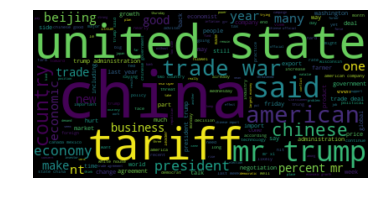

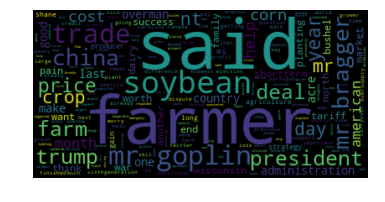

************************************************************


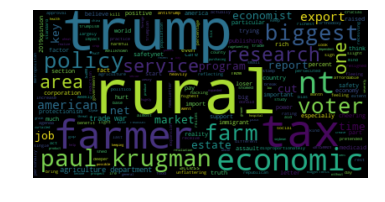

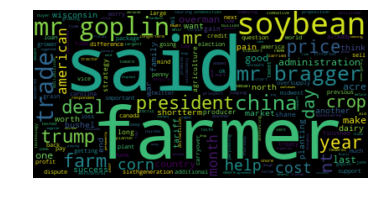

************************************************************


<Figure size 432x288 with 0 Axes>

In [90]:
nca.word_cloud()